# Demo 2: Modern Data Engineering Pipeline

**BME Adatmérnöki alapok – 1. hét | Medallion Architecture**

---

Ez a demó egy valós adatmérnöki pipeline-t mutat be modern eszközökkel, amelyek lokálisan futnak Docker konténerekben.
A **Medallion (Bronze/Silver/Gold)** architektúrát implementáljuk az alábbi komponensekkel:

- **PostgreSQL** – OLTP forrásrendszer (e-commerce adatbázis)
- **MinIO** – S3-kompatibilis objektumtároló (Data Lake)
- **DuckDB** – Analitikai motor (in-process OLAP)

### Architektúra áttekintés

```
┌─────────────┐     ┌──────────────────────────────────────────┐     ┌─────────────┐
│ PostgreSQL  │────→│           MinIO (Data Lake)               │────→│   DuckDB    │
│   (OLTP)    │     │  Bronze → Silver → Gold                  │     │ (Analytics) │
└─────────────┘     └──────────────────────────────────────────┘     └─────────────┘
```

A pipeline lépései:
1. **Extract → Bronze**: Nyers adatok kinyerése PostgreSQL-ből, mentés Parquet formátumban MinIO-ra
2. **Bronze → Silver**: Adattisztítás, JOIN-ok, gazdagítás DuckDB-vel (közvetlenül MinIO-ról olvasva)
3. **Silver → Gold**: Üzleti aggregációk, analytics táblák készítése
4. **Serving**: Dashboard vizualizációk a Gold rétegből

⏱ **Időtartam:** ~15 perc

In [1]:
# Csomagok importálása
import psycopg2
import pandas as pd
from minio import Minio
from minio.error import S3Error
import duckdb
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
from datetime import datetime

plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')
print("Csomagok betöltve!")
print(f"  DuckDB verzió: {duckdb.__version__}")

Csomagok betöltve!
  DuckDB verzió: 1.4.4


## 0. MinIO Data Lake inicializálás

A **MinIO** egy S3-kompatibilis objektumtároló, amely lokálisan fut Docker-ben.
Létrehozunk egy `datalake` nevű bucket-et három réteggel (prefix):

- `bronze/` – Nyers, változtatás nélküli adatok
- `silver/` – Tisztított, transzformált adatok
- `gold/` – Aggregált, üzleti célú adatok

A fájlokat a **MinIO Console** webes felületen is megtekinthetjük:  
**http://localhost:9001** (felhasználó: `minioadmin`, jelszó: `minioadmin`)

In [2]:
# === MinIO kliens és bucket inicializálás ===
minio_client = Minio(
    "minio:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False
)

BUCKET = "datalake"

# Bucket létrehozás (ha nem létezik)
if not minio_client.bucket_exists(BUCKET):
    minio_client.make_bucket(BUCKET)
    print(f"'{BUCKET}' bucket létrehozva")
else:
    print(f"'{BUCKET}' bucket már létezik")

print(f"\nMinIO Console: http://localhost:9001")
print(f"Credentials: minioadmin / minioadmin")

'datalake' bucket létrehozva

MinIO Console: http://localhost:9001
Credentials: minioadmin / minioadmin


## 1. Extract → Bronze réteg

A **Bronze** réteg a forrásrendszerből kinyert nyers adatokat tartalmazza, mindenféle transzformáció nélkül.

Lépések:
1. Csatlakozás a PostgreSQL OLTP adatbázishoz
2. Mind a 4 tábla kinyerése (`customers`, `products`, `orders`, `order_items`)
3. Mentés **Parquet** formátumban a MinIO `bronze/` rétegébe

Ez a klasszikus **ELT** (Extract-Load-Transform) minta: először kinyerjük és betöltjük az adatokat,
a transzformációt később végezzük el.

In [3]:
# === EXTRACT → BRONZE: PostgreSQL → MinIO (raw Parquet) ===
conn = psycopg2.connect(
    host="postgres", port=5432,
    dbname="ecommerce", user="dataeng", password="dataeng2024"
)

TABLES = ["customers", "products", "orders", "order_items"]
bronze_stats = {}

for table in TABLES:
    # Extract
    df = pd.read_sql(f"SELECT * FROM {table}", conn)
    
    # Convert to Parquet bytes
    parquet_buffer = io.BytesIO()
    df.to_parquet(parquet_buffer, engine="pyarrow", index=False)
    parquet_buffer.seek(0)
    size = parquet_buffer.getbuffer().nbytes
    
    # Upload to MinIO bronze layer
    object_name = f"bronze/{table}.parquet"
    minio_client.put_object(
        BUCKET, object_name, parquet_buffer, size,
        content_type="application/octet-stream"
    )
    
    bronze_stats[table] = {"rows": len(df), "size_kb": size / 1024}
    print(f"  {table:15s} → {object_name:35s} ({len(df):4d} sor, {size/1024:.1f} KB)")

conn.close()

print(f"\nBronze réteg kész! {sum(s['rows'] for s in bronze_stats.values())} sor összesen")

  customers       → bronze/customers.parquet            (  20 sor, 5.3 KB)
  products        → bronze/products.parquet             (  15 sor, 3.5 KB)
  orders          → bronze/orders.parquet               (  30 sor, 3.6 KB)
  order_items     → bronze/order_items.parquet          (  54 sor, 4.4 KB)

Bronze réteg kész! 119 sor összesen


/tmp/ipykernel_206/3033247219.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {table}", conn)


## 2. Bronze → Silver réteg (DuckDB transzformáció)

A **Silver** réteg tisztított, validált és összefűzött (joinolt) adatokat tartalmaz.

A **DuckDB** `httpfs` kiterjesztésével közvetlenül olvassuk a Parquet fájlokat MinIO-ról (S3 protokollon),
végrehajtjuk a transzformációkat (JOIN, típuskonverzió, null-kezelés), majd az eredményt visszaírjuk.

A DuckDB képes S3/MinIO tárolókat adatbázisként kezelni – nem kell előbb letölteni a fájlokat!

**Transzformáció:** 4 tábla JOIN-ja → `orders_enriched` (gazdagított rendelések)

In [4]:
# === BRONZE → SILVER: DuckDB transzformáció ===
con = duckdb.connect()

# S3/MinIO konfiguráció DuckDB-hez
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("SET s3_endpoint='minio:9000';")
con.execute("SET s3_access_key_id='minioadmin';")
con.execute("SET s3_secret_access_key='minioadmin';")
con.execute("SET s3_use_ssl=false;")
con.execute("SET s3_url_style='path';")

# Ellenőrzés: Bronze adatok olvasása MinIO-ról
for table in TABLES:
    count = con.execute(f"SELECT COUNT(*) FROM read_parquet('s3://{BUCKET}/bronze/{table}.parquet')").fetchone()[0]
    print(f"  Bronze {table}: {count} sor")

# Silver transzformáció: Enriched orders (4 tábla JOIN)
print("\nSilver transzformáció: orders_enriched...")
silver_query = f"""
    SELECT 
        o.id AS order_id,
        o.order_date,
        o.status,
        c.name AS customer_name,
        c.city AS customer_city,
        c.email AS customer_email,
        p.name AS product_name,
        p.category AS product_category,
        oi.quantity,
        oi.unit_price,
        (oi.quantity * oi.unit_price) AS line_total,
        CURRENT_TIMESTAMP AS processed_at
    FROM read_parquet('s3://{BUCKET}/bronze/orders.parquet') o
    JOIN read_parquet('s3://{BUCKET}/bronze/customers.parquet') c ON o.customer_id = c.id
    JOIN read_parquet('s3://{BUCKET}/bronze/order_items.parquet') oi ON o.id = oi.order_id
    JOIN read_parquet('s3://{BUCKET}/bronze/products.parquet') p ON oi.product_id = p.id
"""

silver_df = con.execute(silver_query).fetchdf()
print(f"  Eredmény: {len(silver_df)} sor, {len(silver_df.columns)} oszlop")

# Silver Parquet mentés MinIO-ra
parquet_buffer = io.BytesIO()
silver_df.to_parquet(parquet_buffer, engine="pyarrow", index=False)
parquet_buffer.seek(0)
size = parquet_buffer.getbuffer().nbytes
minio_client.put_object(BUCKET, "silver/orders_enriched.parquet", parquet_buffer, size)
print(f"  Mentve: silver/orders_enriched.parquet ({size/1024:.1f} KB)")

silver_df.head(10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Bronze customers: 20 sor
  Bronze products: 15 sor
  Bronze orders: 30 sor
  Bronze order_items: 54 sor

Silver transzformáció: orders_enriched...
  Eredmény: 54 sor, 12 oszlop
  Mentve: silver/orders_enriched.parquet (10.6 KB)


,order_id,order_date,status,customer_name,customer_city,customer_email,product_name,product_category,quantity,unit_price,line_total,processed_at
0,1,2024-01-15 10:30:00,completed,Nagy Péter,Budapest,nagy.peter@example.hu,Laptop Lenovo ThinkPad,Elektronika,1,349990.0,349990.0,2026-02-16 10:48:30.498352+00:00
1,1,2024-01-15 10:30:00,completed,Nagy Péter,Budapest,nagy.peter@example.hu,Mechanikus billentyűzet,Kiegészítő,1,24990.0,24990.0,2026-02-16 10:48:30.498352+00:00
2,2,2024-01-16 14:22:00,completed,Kovács Anna,Budapest,kovacs.anna@example.hu,Sony WH-1000XM5 fejhallgató,Elektronika,1,119990.0,119990.0,2026-02-16 10:48:30.498352+00:00
3,2,2024-01-16 14:22:00,completed,Kovács Anna,Budapest,kovacs.anna@example.hu,Egérpad XXL,Kiegészítő,2,4990.0,9980.0,2026-02-16 10:48:30.498352+00:00
4,3,2024-01-17 09:15:00,shipped,Szabó István,Debrecen,szabo.istvan@example.hu,Samsung Galaxy S24,Elektronika,1,279990.0,279990.0,2026-02-16 10:48:30.498352+00:00
5,4,2024-01-18 16:45:00,completed,Nagy Péter,Budapest,nagy.peter@example.hu,Python programozás könyv,Könyv,2,7990.0,15980.0,2026-02-16 10:48:30.498352+00:00
6,4,2024-01-18 16:45:00,completed,Nagy Péter,Budapest,nagy.peter@example.hu,Data Engineering könyv,Könyv,1,14990.0,14990.0,2026-02-16 10:48:30.498352+00:00
7,5,2024-01-19 11:00:00,pending,Tóth Katalin,Szeged,toth.katalin@example.hu,Irodai forgószék,Bútor,1,49990.0,49990.0,2026-02-16 10:48:30.498352+00:00
8,5,2024-01-19 11:00:00,pending,Tóth Katalin,Szeged,toth.katalin@example.hu,Álló íróasztal,Bútor,1,89990.0,89990.0,2026-02-16 10:48:30.498352+00:00
9,6,2024-01-20 08:30:00,completed,Horváth László,Pécs,horvath.laszlo@example.hu,"27"" Monitor Dell",Elektronika,2,129990.0,259980.0,2026-02-16 10:48:30.498352+00:00


## 3. Silver → Gold réteg (Aggregáció)

A **Gold** réteg üzleti célra optimalizált, aggregált adatokat tartalmaz.
Három analitikai táblát készítünk:

1. **`daily_revenue`** – Napi bevétel és rendelésszám
2. **`customer_segments`** – Ügyfélszegmensek (RFM-jellegű elemzés: Premium / Regular / New)
3. **`product_performance`** – Termék teljesítmény (eladások, bevétel)

Éles környezetben ezek a Gold táblák táplálnák a BI dashboardokat (Tableau, PowerBI, Metabase)
vagy ML modelleket.

In [5]:
# === SILVER → GOLD: Aggregált analytics táblák ===

# Gold 1: Napi bevétel (daily_revenue)
gold_revenue = con.execute(f"""
    SELECT 
        order_date,
        COUNT(DISTINCT order_id) AS order_count,
        SUM(line_total) AS total_revenue,
        AVG(line_total) AS avg_order_value,
        COUNT(DISTINCT customer_name) AS unique_customers
    FROM read_parquet('s3://{BUCKET}/silver/orders_enriched.parquet')
    GROUP BY order_date
    ORDER BY order_date
""").fetchdf()

# Gold 2: Ügyfélszegmensek (customer_segments)
gold_customers = con.execute(f"""
    SELECT 
        customer_name,
        customer_city,
        COUNT(DISTINCT order_id) AS order_count,
        SUM(line_total) AS total_spent,
        AVG(line_total) AS avg_order_value,
        MAX(order_date) AS last_order_date,
        CASE 
            WHEN SUM(line_total) > 500000 THEN 'Premium'
            WHEN SUM(line_total) > 100000 THEN 'Regular'
            ELSE 'New'
        END AS segment
    FROM read_parquet('s3://{BUCKET}/silver/orders_enriched.parquet')
    GROUP BY customer_name, customer_city
    ORDER BY total_spent DESC
""").fetchdf()

# Gold 3: Termék teljesítmény (product_performance)
gold_products = con.execute(f"""
    SELECT 
        product_name,
        product_category,
        SUM(quantity) AS total_qty_sold,
        SUM(line_total) AS total_revenue,
        AVG(unit_price) AS avg_price,
        COUNT(DISTINCT order_id) AS in_orders
    FROM read_parquet('s3://{BUCKET}/silver/orders_enriched.parquet')
    GROUP BY product_name, product_category
    ORDER BY total_revenue DESC
""").fetchdf()

# Mentés MinIO-ra
gold_tables = {
    "gold/daily_revenue.parquet": gold_revenue,
    "gold/customer_segments.parquet": gold_customers,
    "gold/product_performance.parquet": gold_products,
}

for path, df in gold_tables.items():
    buf = io.BytesIO()
    df.to_parquet(buf, engine="pyarrow", index=False)
    buf.seek(0)
    size = buf.getbuffer().nbytes
    minio_client.put_object(BUCKET, path, buf, size)
    print(f"  {path:45s} ({len(df):3d} sor, {size/1024:.1f} KB)")

print(f"\nGold réteg kész! {sum(len(df) for df in gold_tables.values())} sor összesen")

  gold/daily_revenue.parquet                    ( 30 sor, 4.6 KB)
  gold/customer_segments.parquet                ( 20 sor, 6.1 KB)
  gold/product_performance.parquet              ( 15 sor, 5.2 KB)

Gold réteg kész! 65 sor összesen


## 4. Serving – Analytics lekérdezések és Dashboard

A Gold réteg adataiból vizualizációkat készítünk.
Éles környezetben ezek a Gold táblák BI eszközöket (Tableau, PowerBI, Metabase) vagy API végpontokat táplálnának.

Az alábbi dashboard 4 nézetet tartalmaz:
1. Napi bevétel trend
2. Ügyfélszegmensek megoszlása
3. Top 10 termék bevétel szerint
4. Rendelések városonként

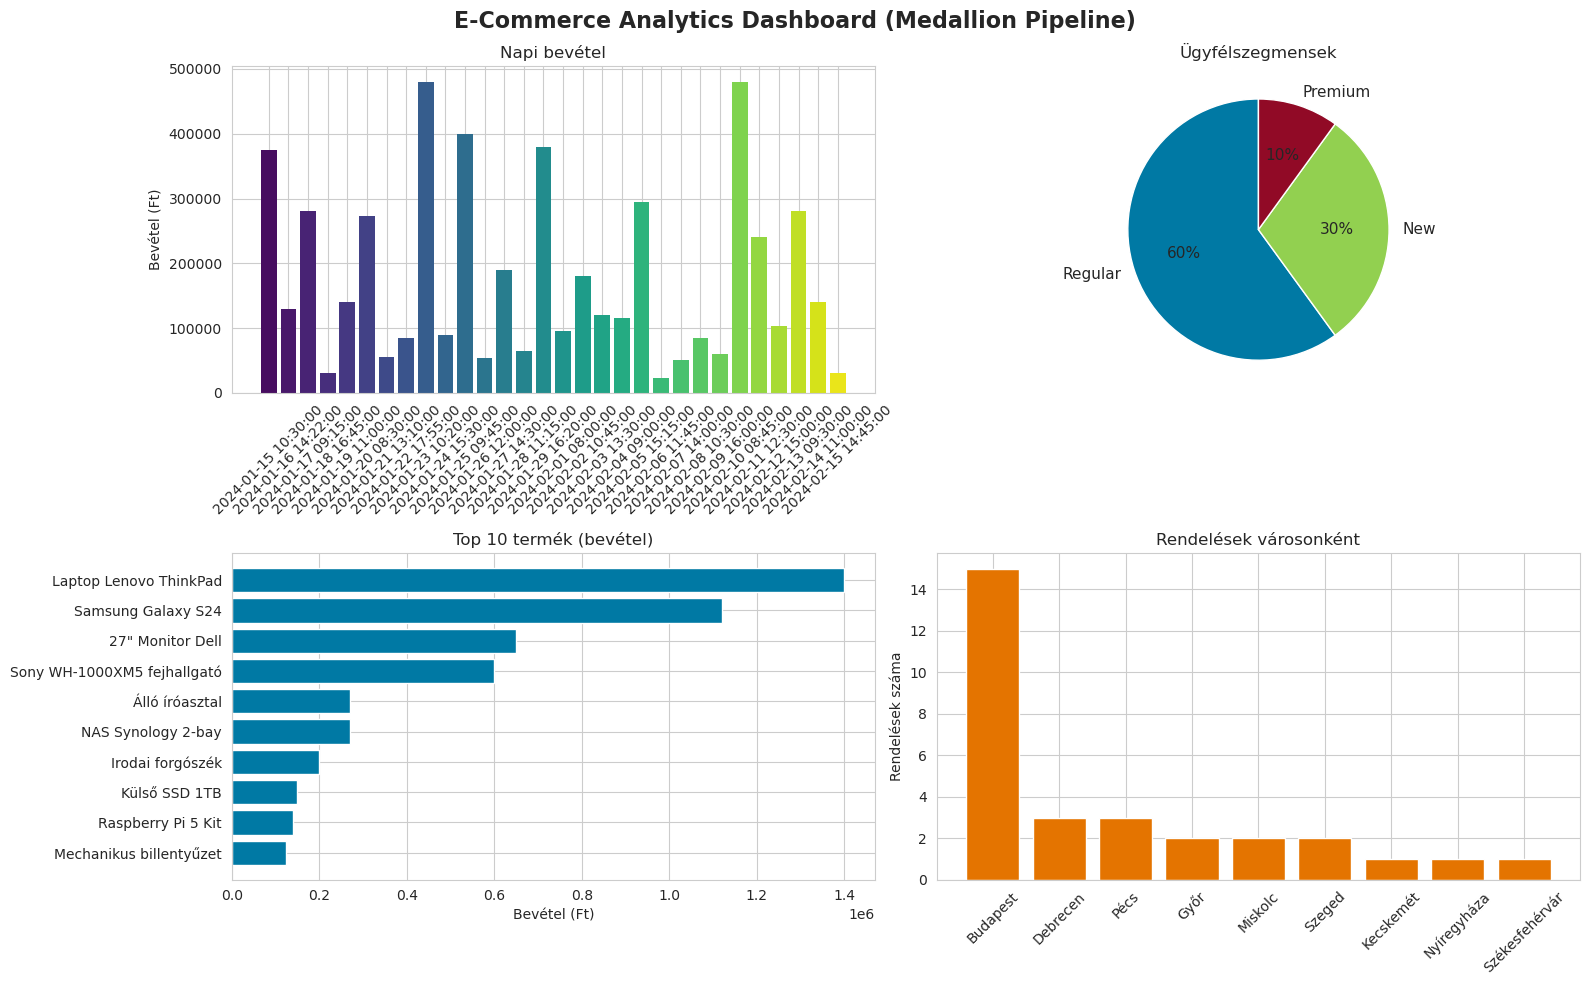

Dashboard mentve: medallion_dashboard.png


In [6]:
# === SERVING: Dashboard a Gold rétegből ===
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("E-Commerce Analytics Dashboard (Medallion Pipeline)", fontsize=16, fontweight='bold')

# --- 4.1 Napi bevétel trend ---
ax1 = axes[0, 0]
ax1.bar(gold_revenue["order_date"].astype(str), gold_revenue["total_revenue"], 
        color=sns.color_palette("viridis", len(gold_revenue)), edgecolor='none')
ax1.set_title("Napi bevétel")
ax1.set_ylabel("Bevétel (Ft)")
ax1.tick_params(axis='x', rotation=45)

# --- 4.2 Ügyfélszegmensek ---
ax2 = axes[0, 1]
segment_counts = gold_customers["segment"].value_counts()
colors_seg = {"Premium": "#910A26", "Regular": "#0079A4", "New": "#92D050"}
ax2.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.0f%%',
        colors=[colors_seg.get(s, "#ccc") for s in segment_counts.index],
        startangle=90, textprops={'fontsize': 11})
ax2.set_title("Ügyfélszegmensek")

# --- 4.3 Top 10 termék bevétel szerint ---
ax3 = axes[1, 0]
top10 = gold_products.head(10)
ax3.barh(top10["product_name"], top10["total_revenue"], color="#0079A4")
ax3.set_title("Top 10 termék (bevétel)")
ax3.set_xlabel("Bevétel (Ft)")
ax3.invert_yaxis()

# --- 4.4 Rendelések városonként ---
ax4 = axes[1, 1]
city_orders = gold_customers.groupby("customer_city")["order_count"].sum().sort_values(ascending=False)
ax4.bar(city_orders.index, city_orders.values, color="#E47400")
ax4.set_title("Rendelések városonként")
ax4.set_ylabel("Rendelések száma")
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("/home/jovyan/work/medallion_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("Dashboard mentve: medallion_dashboard.png")

## 5. Data Lake áttekintés

Ellenőrizzük a Data Lake struktúráját. Mindhárom réteg (Bronze, Silver, Gold) a MinIO `datalake` bucket-ben található.

A fájlokat a **MinIO Console** webes felületen is böngészhetjük: **http://localhost:9001**

In [7]:
# === DATA LAKE ÁTTEKINTÉS ===
print("=" * 70)
print("MEDALLION DATA LAKE STRUKTÚRA (MinIO)")
print("=" * 70)

layers = {"bronze": "Nyers adatok (raw extract)", 
          "silver": "Tisztított, joinolt adatok", 
          "gold": "Aggregált analytics táblák"}

total_size = 0
total_objects = 0

for layer, description in layers.items():
    print(f"\n{'─' * 70}")
    print(f"  {layer.upper()} réteg – {description}")
    print(f"{'─' * 70}")
    
    objects = list(minio_client.list_objects(BUCKET, prefix=f"{layer}/"))
    layer_size = 0
    for obj in objects:
        size_kb = obj.size / 1024
        layer_size += obj.size
        
        # Read row count with DuckDB
        row_count = con.execute(
            f"SELECT COUNT(*) FROM read_parquet('s3://{BUCKET}/{obj.object_name}')"
        ).fetchone()[0]
        
        print(f"    {obj.object_name:45s}  {row_count:6d} sor  {size_kb:8.1f} KB")
    
    total_size += layer_size
    total_objects += len(objects)
    print(f"    {'Összesen:':45s}  {layer_size/1024:14.1f} KB")

print(f"\n{'=' * 70}")
print(f"  Data Lake összesen: {total_objects} objektum, {total_size/1024:.1f} KB")
print(f"  MinIO Console: http://localhost:9001")
print(f"{'=' * 70}")

MEDALLION DATA LAKE STRUKTÚRA (MinIO)

──────────────────────────────────────────────────────────────────────
  BRONZE réteg – Nyers adatok (raw extract)
──────────────────────────────────────────────────────────────────────
    bronze/customers.parquet                           20 sor       5.3 KB
    bronze/order_items.parquet                         54 sor       4.4 KB
    bronze/orders.parquet                              30 sor       3.6 KB
    bronze/products.parquet                            15 sor       3.5 KB
    Összesen:                                                16.9 KB

──────────────────────────────────────────────────────────────────────
  SILVER réteg – Tisztított, joinolt adatok
──────────────────────────────────────────────────────────────────────
    silver/orders_enriched.parquet                     54 sor      10.6 KB
    Összesen:                                                10.6 KB

──────────────────────────────────────────────────────────────────────
  G

## Összefoglalás

A teljes Medallion pipeline áttekintése:

| Réteg | Tartalom | Eszköz | Fájlok |
|---|---|---|---|
| **Forrás** | OLTP adatbázis | PostgreSQL | 4 tábla |
| **Bronze** | Nyers extract | psycopg2 + MinIO | 4 Parquet fájl |
| **Silver** | Tisztított, joinolt | DuckDB (httpfs) | 1 enriched Parquet |
| **Gold** | Aggregált analytics | DuckDB | 3 analytics Parquet |
| **Serving** | Dashboard | matplotlib | Vizualizáció |

---

### Skálázhatóság

Ez a pipeline lokálisan fut Docker-ben, de ugyanez az architektúra skálázható felhőre:

- **PostgreSQL** → Amazon RDS / Azure SQL
- **MinIO** → Amazon S3 / Azure Blob Storage
- **DuckDB** → Amazon Athena / Snowflake / Databricks

A **Medallion pattern** iparági standard a modern data engineering-ben.
A Databricks, a Snowflake és más nagy platformok is ezt az architektúrát ajánlják.

In [8]:
# Cleanup
con.close()
print("DuckDB kapcsolat lezárva.")
print("A MinIO-ban tárolt adatok megmaradnak a konténer újraindításáig.")
print("\nLeállítás: docker compose down")
print("Adatok törlésével: docker compose down -v")

DuckDB kapcsolat lezárva.
A MinIO-ban tárolt adatok megmaradnak a konténer újraindításáig.

Leállítás: docker compose down
Adatok törlésével: docker compose down -v
